In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import time
import itertools

In [529]:
df = pd.read_csv("Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
loads = np.asarray(df["crawfordCrescent_F2"])

In [530]:
h = 48
d = 161

rates = pd.read_csv("agile_rates_2019.csv")
buyPrice = np.asarray(rates["unit_rate_incl_vat"].iloc[d*h:d*h+h])
priceDict = dict(enumerate(buyPrice))

In [7]:
load_data = np.loadtxt("Final/filterData.txt")
peakLoad = np.max(load_data, axis=1)

filter_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)


In [531]:
class Battery:
    def __init__(self, maxSOC, maxChargeRate, maxDischargeRate, chargeEfficiency, dischargeEfficiency):
        self.maxSOC = maxSOC
        self.maxChargeRate = maxChargeRate
        self.maxDischargeRate = maxDischargeRate
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency



day = loads[d*h:d*h+h]
peakLoad = max(loads)



SOC = max(loads)*0.25  # in kWh
D = max(loads)*0.25    # in kW
C = D/2                # in kW
efficiency = 0.95


batt = Battery(SOC, C, D, efficiency, efficiency)

In [532]:
loadDict = dict(enumerate(day))

In [533]:
# Initialise model
m = ConcreteModel()

# Create time to be used as index
m.Time = RangeSet(0, h-1)

In [534]:
# Declare Decision variables
m.SOC = Var(m.Time, bounds=(0,batt.maxSOC), initialize=0) # State of Charge variable, cant be greater than max SOC
m.posDeltaSOC = Var(m.Time, initialize=0) # Change of State of Charge in kWh
m.negDeltaSOC = Var(m.Time, initialize=0)
m.chargingWatts = Var(m.Time, bounds=(0,batt.maxChargeRate), initialize=0) # Energy in grid, converted to Watts
m.dischargingWatts = Var(m.Time, bounds=(0,batt.maxDischargeRate), initialize=0)
m.gridImport = Var(m.Time, domain=NonNegativeReals, initialize=loadDict) # Net load from grid




In [535]:
# Boolean variables, used to determine wether battery is charging or discharging
m.Bool_char = Var(m.Time, within=Boolean) # 1 if battery is charging
m.Bool_dis = Var(m.Time, within=Boolean, initialize=0) # 1 if battery is discharging


In [536]:
m.dayLoads = Param(m.Time, initialize=loadDict)
m.priceBuy = Param(m.Time, initialize=priceDict)

In [537]:
#m.chargeEfficiency = Param(initialize=batt.chargeEfficiency)
#m.dischargeEfficiency = Param(initialize=batt.dischargeEfficiency)
m.chargingLimit = Param(initialize=batt.maxChargeRate)
m.dischargingLimit = Param(initialize=batt.maxDischargeRate)

In [538]:
# Constraints
# SOC is equal to SOC at previous time plus change in SOC
def SOC_rule(m,t):
    if t==0:
        return(m.SOC[t] == 0)
    else:
        return(m.SOC[t] == m.SOC[t-1] + m.posDeltaSOC[t] - m.negDeltaSOC[t])
m.Batt_SOC = Constraint(m.Time, rule=SOC_rule)

In [539]:
def charging_rule(m,t):
    return m.chargingWatts[t] <= m.chargingLimit
m.charging_rule = Constraint(m.Time, rule=charging_rule)

def discharging_rule(m,t):
    return m.dischargingWatts[t] <= m.dischargingLimit
m.discharging_rule = Constraint(m.Time, rule=discharging_rule)

# ensure charging rate obeyed
def E_charging_rate_rule(m,t):
    return m.posDeltaSOC[t] == m.chargingWatts[t] * 0.5
m.chargingLimit_cons = Constraint(m.Time, rule=E_charging_rate_rule)

# ensure DIScharging rate obeyed
def E_discharging_rate_rule(m,t):
    return m.negDeltaSOC[t] == m.dischargingWatts[t] * 0.5
m.dischargingLimit_cons = Constraint(m.Time, rule=E_discharging_rate_rule)

def demand_rule(m,t):
    return m.gridImport[t] == m.dayLoads[t] + m.chargingWatts[t] - m.dischargingWatts[t] 
m.demand_rule = Constraint(m.Time, rule=demand_rule)

In [540]:
# def Bool_char_rule_1(m,t):
#     bigM = 500000
#     return(m.posDeltaSOC[t] >= -bigM*(m.Bool_char[t]))
# m.Batt_char1 = Constraint(m.Time, rule=Bool_char_rule_1)

# def Bool_char_rule_2(m,t):
#     bigM = 500000
#     return(m.posDeltaSOC[t] <= 0+bigM*(1 - m.Bool_dis[t]))
# m.Batt_char2 = Constraint(m.Time, rule=Bool_char_rule_2)

# def Bool_char_rule_3(m,i):
#     bigM = 500000
#     return((m.negDeltaSOC[i]) <= bigM*(m.Bool_dis[i]))
# m.Batt_cd3 = Constraint(m.Time,rule=Bool_char_rule_3)

# def Bool_char_rule_4(m,i):
#     bigM=500000
#     return((m.negDeltaSOC[i]) >= 0-bigM*(1-m.Bool_char[i]))
# m.Batt_cd4 = Constraint(m.Time,rule=Bool_char_rule_4)

# def Bool_char_dis(m,t):
#     return(m.Bool_char[t] + m.Bool_dis[t], 1)
# m.Batt_char_dis = Constraint(m.Time, rule=Bool_char_dis)

In [541]:
def pos_or_neg_charge(m,t):
    return(m.chargingWatts[t] * m.dischargingWatts[t] == 0)
m.pos_or_neg = Constraint(m.Time, rule=pos_or_neg_charge)

In [542]:
# # Account for charging efficiency
# def pos_E_in_rule(m,t):
#     return m.chargingWatts[t] == m.posDeltaSOC[t]/m.chargeEfficiency
# m.posEIn_cons = Constraint(m.Time, rule=pos_E_in_rule)

# # Account for discharging efficiency
# def neg_E_out_rule(m,t):
#     return m.dischargingWatts[t] == m.negDeltaSOC[t]*m.dischargeEfficiency
# m.negEOut_cons = Constraint(m.Time, rule=neg_E_out_rule)

In [543]:
# m.is_max = Var(m.Time, within=Boolean)
# m.maxLoad = Var(m.Time, within=NonNegativeReals) # Stores max load value

# def only_one_max(m,t):
#     return sum(m.is_max[i] for i in m.Time) == 1
# m.only_one_max = Constraint(m.Time, rule=only_one_max)

# # Forces maxLoad to be 0 if is_max is 0
# def limit_max(m,t):
#     bigM = 5000
#     return m.maxLoad[t] <= bigM * m.is_max[t]
# m.limit_max = Constraint(m.Time, rule=limit_max)

# def find_max(m,t):
#     bigM = 5000
#     return m.maxLoad[t] + bigM*(1 - m.is_max[t]) >= (m.maxLoad[i] for i in m.Time)

In [544]:
m.maxLoad = Var(within=NonNegativeReals)


def Peak_Rule(m, t):
    return m.maxLoad >= m.gridImport[t]

m.Bound_Peak = Constraint(m.Time,rule=Peak_Rule)

In [545]:
# def is_max(m,t):
#     return m.maxLoad >= m.netLoad[t]
# m.is_max = Constraint(m.Time, rule=is_max)
 

In [546]:
# Objective function is max of loads in the day
def Obj_func(m):
    return m.maxLoad
m.max_load = Objective(rule=Obj_func, sense=minimize)

In [547]:
opt = SolverFactory("gurobi")
opt.options['NonConvex'] = 2

In [548]:
t = time.time()
results = opt.solve(m)
elapsed = time.time() - t
print ('Time elapsed:', elapsed)

Time elapsed: 0.21399903297424316


In [549]:
j = 0
for v in m.component_objects(Var, active=True):
    print (j, v.getname())
    j+=1

0 SOC
1 posDeltaSOC
2 negDeltaSOC
3 chargingWatts
4 dischargingWatts
5 gridImport
6 Bool_char
7 Bool_dis
8 maxLoad


In [550]:
outputVars = np.zeros((10,len(day)))

In [551]:
j = 0
for v in m.component_objects(Var, active=True):
    print (v.getname())
    #print varobject.get_values()
    varobject = getattr(m, str(v))
    for index in varobject:
        outputVars[j,index] = varobject[index].value
    j+=1
    if j>=10:
        break


SOC
posDeltaSOC
negDeltaSOC
chargingWatts
dischargingWatts
gridImport
Bool_char
Bool_dis
maxLoad


<bound method Figure.show of <Figure size 1080x576 with 2 Axes>>

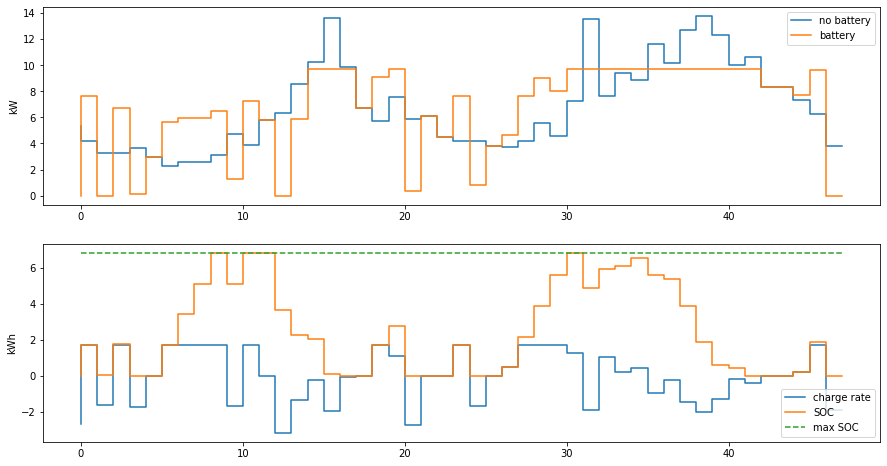

In [552]:
newLoad = outputVars[5]
SOC = outputVars[0]
chargeRate = outputVars[1] - outputVars[2]
maxSOC = np.ones(48) * batt.maxSOC

y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].step(y,day, label="no battery")
axs[0].step(y,newLoad, label="battery")
axs[0].legend()
axs[0].set_ylabel("kW")

axs[1].step(y,chargeRate, label="charge rate")
axs[1].step(y,SOC,label="SOC")
axs[1].plot(y,maxSOC, label="max SOC", linestyle="dashed")
axs[1].legend()
axs[1].set_ylabel("kWh")


fig.set_figheight(8)
fig.set_figwidth(15)
fig.show

In [553]:

# sumPre = 0
# for i in range(48):
#     sumPre += buyPrice[i]*day[i]

#sumPre
print(sum(buyPrice[i]*day[i] for i in range(48)))

print(sum(buyPrice[i]*newLoad[i] for i in range(48)))

4284.635604899999
4263.77656812784


In [554]:
len(m.component_objects)

TypeError: object of type 'method' has no len()